# SA13 master catalogue
## Checks and diagnostics
There is very little data on SA13 so there is very little data to compare to.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3, venn2

from herschelhelp_internal.masterlist import nb_compare_mags, nb_ccplots, nb_histograms, find_last_ml_suffix

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_sa13_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

Diagnostics done using: master_catalogue_sa13_20171115.fits


## I - Summary of wavelength domains

In [4]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

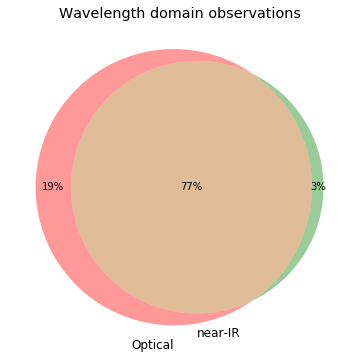

In [5]:

venn2(
    [
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 3)
    ],
    set_labels=('Optical', 'near-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

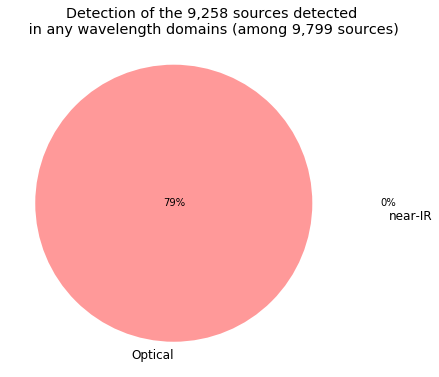

In [6]:

venn2(
    [
        np.sum(flag_det[flag_obs == 3] == 1),
        np.sum(flag_det[flag_obs == 3] == 2),
        np.sum(flag_det[flag_obs == 3] == 3)
    ],
    set_labels=( 'Optical', 'near-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [7]:
u_bands = []
g_bands = ["BASS g"]
r_bands = ["BASS r"]
i_bands = []
z_bands = ["BASS z"]
y_bands = []


### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


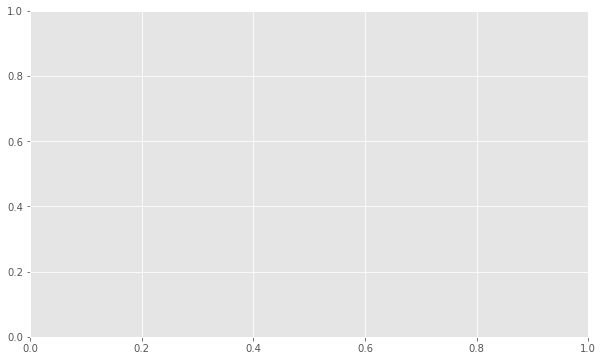

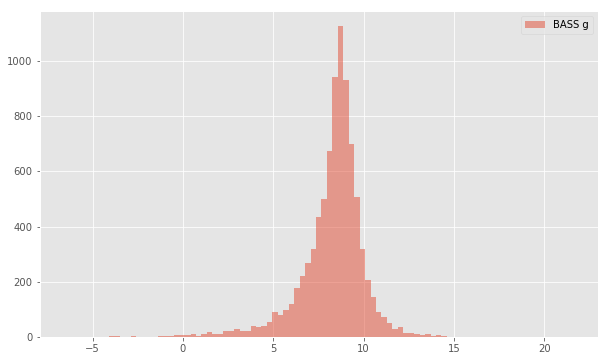

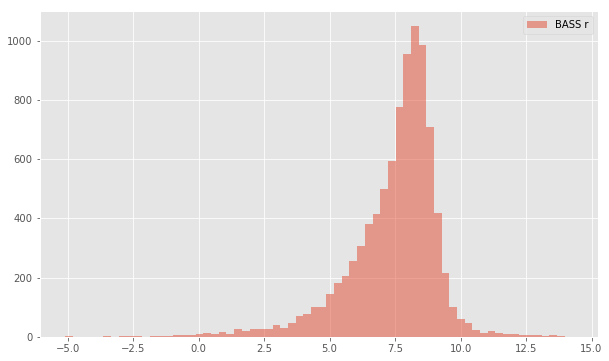

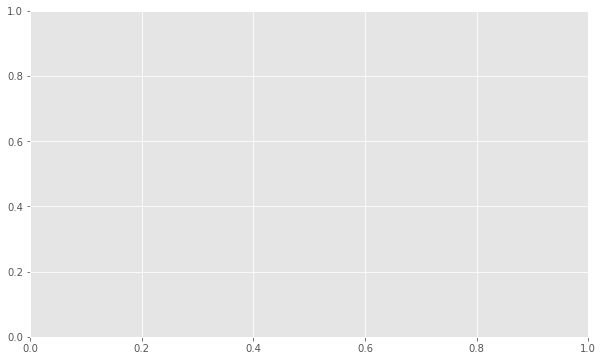

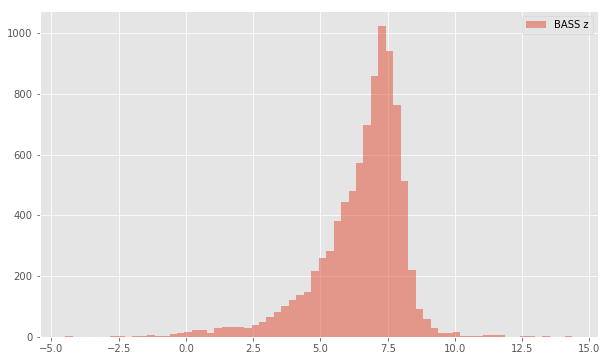

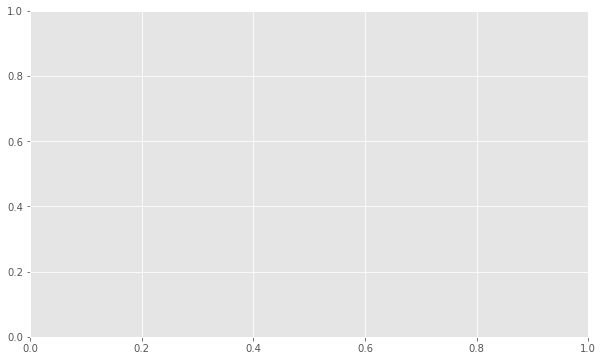

In [8]:
for bands in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

We compare one to one each magnitude in similar bands.

In [9]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    for band1, band2 in itertools.combinations(band_of_a_kind, 2):
        
        basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
        
        col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
        
        col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (total)".format(band1), "{} (total)".format(band2)))

## III - Comparing magnitudes to reference bands

Cross-match the master list to 2MASS to compare magnitudes.

In [10]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.b - Comparing J  band to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |



In [11]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [12]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_SA13.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

WFCAM J (total) - 2MASS J:
- Median: 0.01
- Median Absolute Deviation: 0.04
- 1% percentile: -0.7482610212613876
- 99% percentile: 0.20659443177205777


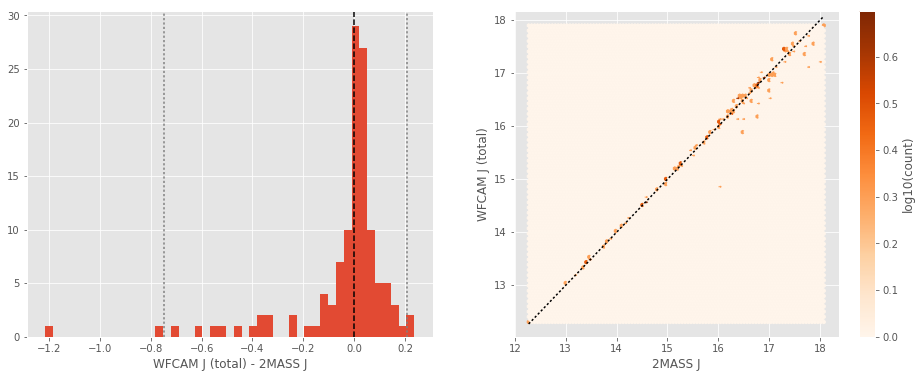

In [13]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_wfcam_j'][ml_twomass_idx],
                labels=("2MASS J", "WFCAM J (total)"))

Based on the first run of the above graph it became clear that uhs requires conversion from Vega to AB.

## Keeping only sources with good signal to noise ratio

From here, we are only comparing sources with a signal to noise ratio above 3, i.e. roughly we a magnitude error below 0.3.

*To make it easier, we are setting to NaN in the catalogue the magnitudes associated with an error above 0.3 so we can't use these magnitudes after the next cell.*

In [14]:
for error_column in [_ for _ in master_catalogue.colnames if _.startswith('merr_')]:
    column = error_column.replace("merr", "m")
    keep_mask = np.isfinite(master_catalogue[error_column])
    keep_mask[keep_mask] &= master_catalogue[keep_mask][error_column] <= 0.3
    master_catalogue[column][~keep_mask] = np.nan

## IV - Comparing aperture magnitudes to total ones.

Number of source used: 9 / 9799 (0.09%)


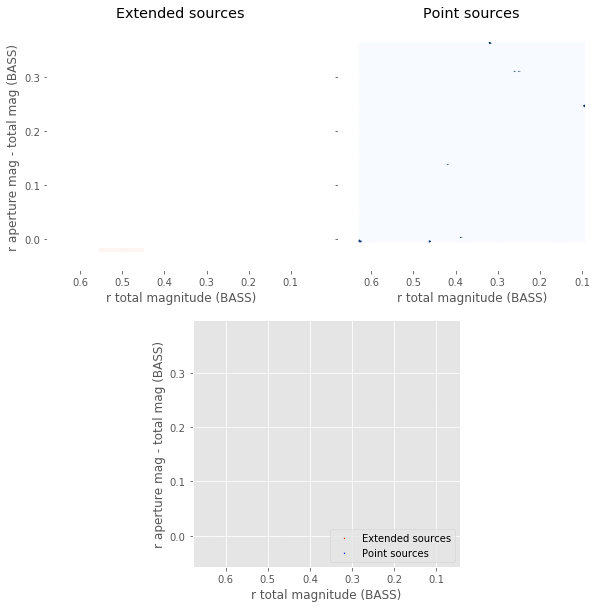

In [15]:
nb_ccplots(
    master_catalogue['m_bass_r'],
    master_catalogue['m_ap_bass_r'] - master_catalogue['m_bass_r'],
    "r total magnitude (BASS)", "r aperture mag - total mag (BASS)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

Number of source used: 103 / 9799 (1.05%)


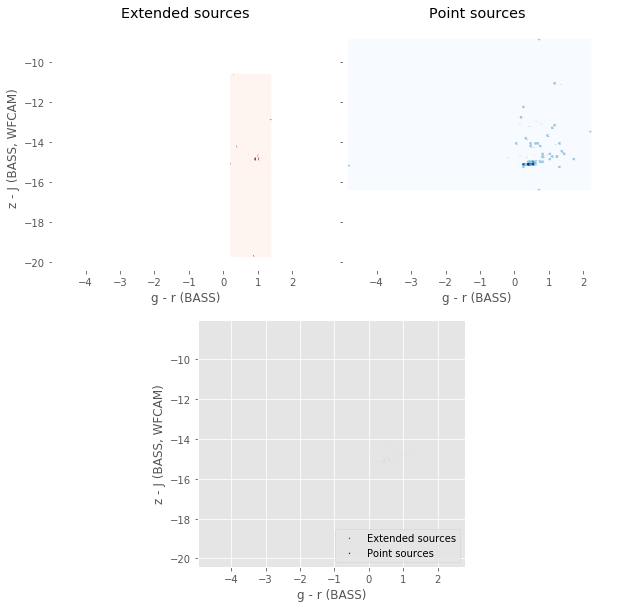

In [16]:
nb_ccplots(
    master_catalogue['m_bass_g'] - master_catalogue['m_bass_r'],
    master_catalogue['m_bass_z'] - master_catalogue['m_wfcam_j'],
    "g - r (BASS)", "z - J (BASS, WFCAM)",
    master_catalogue["stellarity"]
)